1.1 What is Knowledge Graph?
A knowledge graph is a way of storing data that resulted from an information extraction task. Many basic implementations of knowledge graphs make use of a concept we call triple, that is a set of three items(a subject, a predicate and an object) that we can use to store information about something.

We can define a graph as a set of nodes and edges

Node A and Node B here are two different entities. These nodes are connected by an edge that represents the relationship between the two nodes. Now, this is the smallest knowledge graph we can build – it is also known as a triple.Knowledge Graph’s come in a variety of shapes and sizes.

1.2 Data Representation in Knowledge Graph?
Let's take this sentence as an example:

London is the capital of England. Westminster is located in London.

After some basic processing which we will see later, we would 2 triples like this:

(London, be capital, England), (Westminster, locate, London)

So in this example we have three unique entities(London, England and Westminster) and two relations(be capital, locate). To build a knowledge graph, we only have two associated nodes in the graph with the entities and vertices with the relations and we will get something like this:Manually building a knowledge graph is not scalable. Nobody is going to go through thousands of documents and extract all the entities and the relations between them!

That’s why machines are more suitable to perform this task as going through even hundreds or thousands of documents is child’s play for them. But then there is another challenge – machines do not understand natural language. This is where Natural Language Processing (NLP) comes into the picture.

To build a knowledge graph from the text, it is important to make our machine understand natural language. This can be done by using NLP techniques such as sentence segmentation, dependency parsing, parts of speech tagging, and entity recognition.

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/wiki_sentences_v2.csv")
candidate_sentences.shape


(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5)


3727                                                                        it had no. 1
3257                                                 conversion was out of the question.
1211                           later, allu arjun was eventually selected to do the role.
2200    employing fantasy and comedic elements, maelström is narrated by a talking fish.
1731                                                  as in hollywood, very few succeed.
Name: sentence, dtype: object

1.4 Sentence Segmentation
The first step in building a knowledge graph is to split the text document or article into sentences. Then, we will shortlist only those sentences in which there is exactly 1 subject and 1 object.

In [4]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


1.5 Entities Extraction
The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.

However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence.

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

So, I have created a function below to extract the subject and the object (entities) from a sentence while also overcoming the challenges mentioned above. I have partitioned the code into multiple chunks for your convenience:

In [5]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Chunk 1

Defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

Chunk 2

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

Chunk 3

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

Chunk 4

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

Chunk 5

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

Let’s test this function on a sentence:

In [6]:
get_entities("the film had 200 patents")


['film', '200  patents']

In [7]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:41<00:00, 103.24it/s]


In [8]:
entity_pairs[10:20]


[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men']]

1.6 Relations Extraction
Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [9]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # Define the pattern
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep', 'OP':'?'},
               {'DEP':'agent', 'OP':'?'},
               {'POS':'ADJ', 'OP':'?'}]

    matcher.add("matching_1", [pattern])  # Use a list to pass the pattern

    matches = matcher(doc)
    k = len(matches) - 1

    # Use the last match to extract the span
    span = doc[matches[k][1]:matches[k][2]]

    return span.text

In [10]:
get_relation("John completed the task")


'completed'

In [11]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


100%|██████████| 4318/4318 [00:41<00:00, 102.81it/s]


In [12]:
relations

['decides',
 'heard in',
 'paralyzed by',
 'set on',
 'wails with',
 "'s",
 'joined',
 'revealed',
 'revealed as',
 'tried',
 'went through',
 'circling',
 'supervised',
 'features',
 'is',
 'injures',
 'tasked with',
 'attacked by',
 'portrays',
 'return',
 'stand',
 'considered for',
 'served as',
 'completed on',
 'released',
 'released',
 'distributed by',
 'ended',
 'chandler',
 'dedicated to executive',
 'approach former',
 'frees',
 'disowns',
 'appears as',
 'credited as',
 'stated',
 'empathizing with',
 'was',
 'contributed to',
 'took',
 'changed',
 'became',
 'look like big',
 'perform',
 'managed',
 'released on',
 'written by',
 'conducted by',
 'released',
 'released',
 'scheduled',
 'offered in',
 'includes',
 'include',
 'are ready',
 'was',
 'tend',
 'include',
 'themes',
 'is',
 'are',
 'had many',
 'supervises',
 'oversee',
 'credited',
 'start in',
 'started as',
 'attended',
 'use different',
 'take',
 'equipped with sound',
 'designed for',
 'cooperates with',
 '

In [13]:
pd.Series(relations).value_counts()[:50]


is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
became            31
have              31
has               30
become            28
released in       27
included          23
had               21
produced          21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
written by        13
wrote             13
received          13
introduced in     13
went              13
wanted            12
sold              12
began in          11
set               11
began             11
cast as           11
won               11
gave              10
directed          10
includes          10
gives              9
going              9
produced in        9
opened             9
features     

In [14]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [15]:
kg_df

source                           target          edge
0                connie                              own       decides
1         later  scream                         distance      heard in
2             christian                      then  elder  paralyzed by
3                temple                             fire        set on
4                                       outside cult him    wails with
...                 ...                              ...           ...
4313       confidencial                 negatively  film     responded
4314        le parisien                 five star rating          gave
4315  museum collection               37,000 film titles      includes
4316        predecessor             historical film 1946           was
4317                     1920'sfilmstar alexander binder      garbo by

[4318 rows x 3 columns]

In [16]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

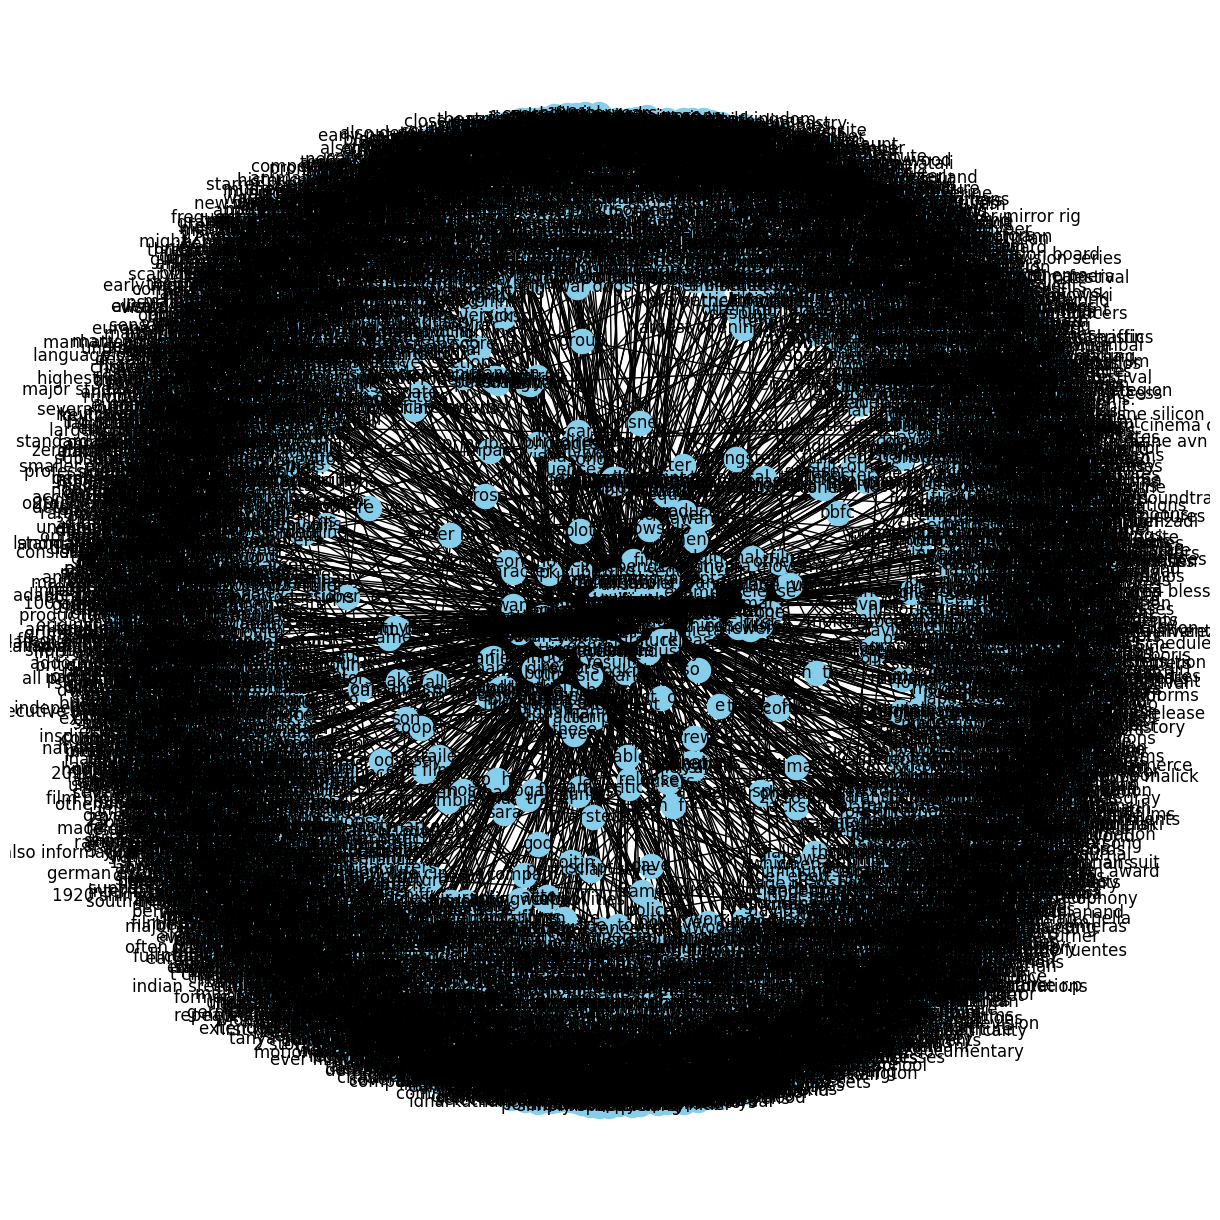

In [17]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [18]:
kg_df[kg_df['edge']=="composed by"]

source                target         edge
325                  music    benjamin wallfisch  composed by
334                  music    benjamin wallfisch  composed by
342         musical  score  incidental  stothart  composed by
425      soundtrack  score          a. r. rahman  composed by
706                 themes       sanchit balhara  composed by
826             soundtrack            vidyasagar  composed by
1167                 music                sam c.  composed by
1208     soundtrack  score           ilaiyaraaja  composed by
1218            film score          a. r. rahman  composed by
1289                 music           brian tyler  composed by
1308                 score         thomas newman  composed by
1322                 score         thomas newman  composed by
1435            soundtrack      jerome pushparaj  composed by
1625      background score      daniel b. george  composed by
1643      background score      daniel b. george  composed by
2165            soundtrack   anirudh ravichander  composed by
2177                 music                  ravi  composed by
2556                 music       michael stearns  composed by
2714                 music   madhavapeddi suresh  composed by
2791                 music        heitor pereira  composed by
2824     soundtrack  score           mani sharma  composed by
2834     soundtrack  score           mani sharma  composed by
3238                 score        harris jayaraj  composed by
3282                 music        marco beltrami  composed by
3283                 music        marco beltrami  composed by
3317                 music                    r.  composed by
3525  original music score            mark isham  composed by
3892            soundtrack       m. m. keeravani  composed by
3921            soundtrack       m. m. keeravani  composed by
3952                 score          vijay antony  composed by
4016                 score             brian eno  composed by
4124                 music            nick urata  composed by
4218                 music                pritam  composed by
4306                 music          a. r. rahman  composed by

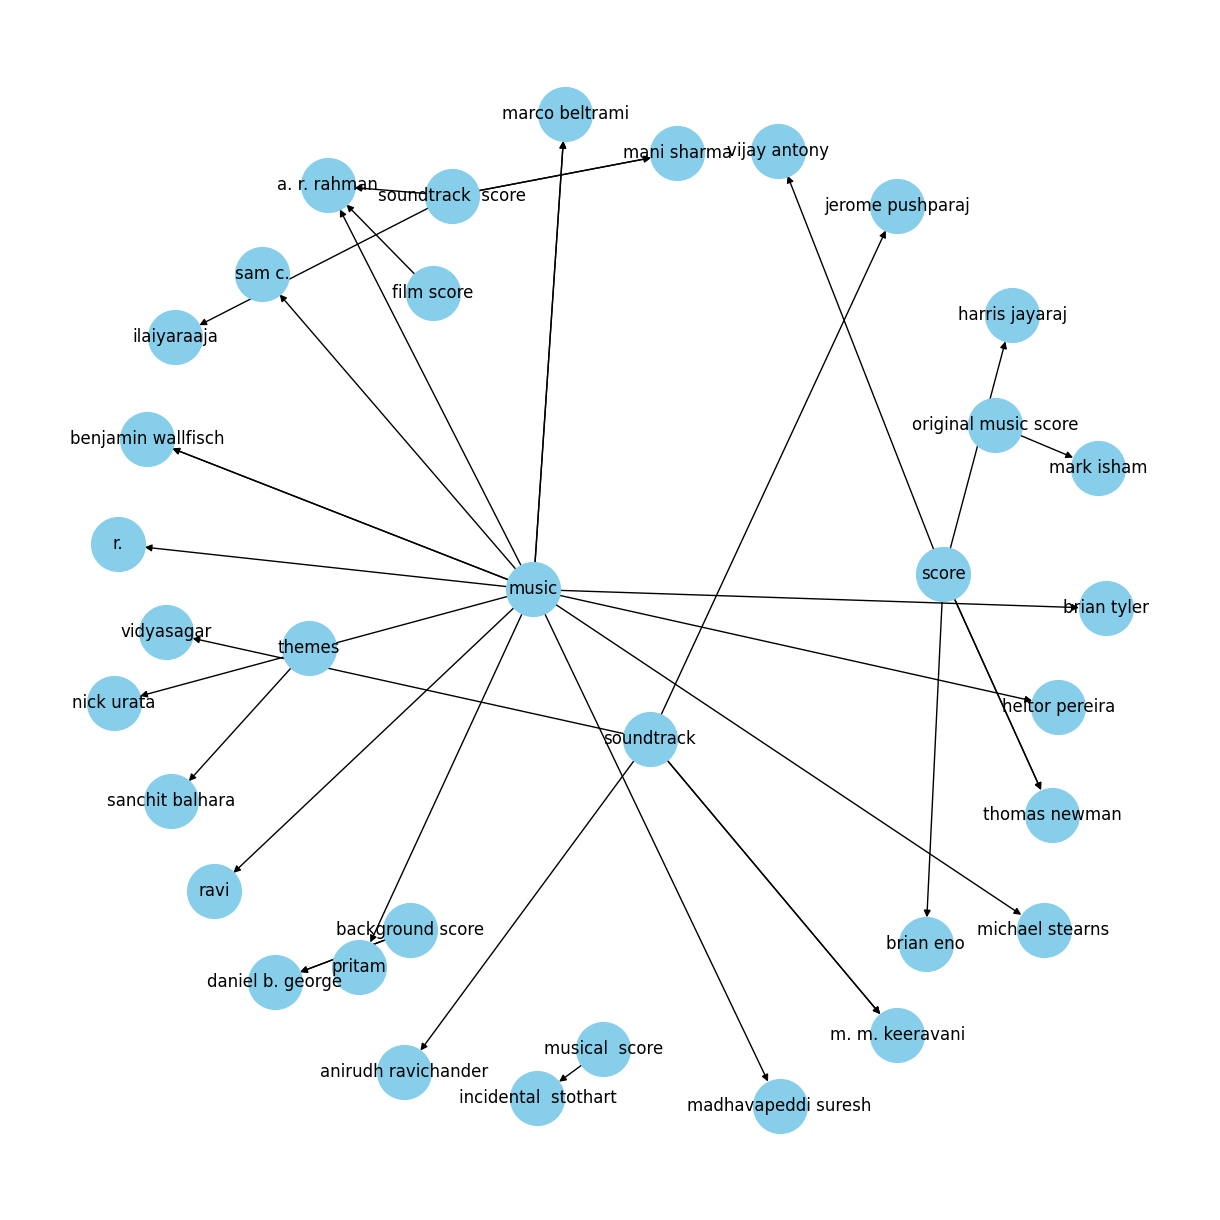

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

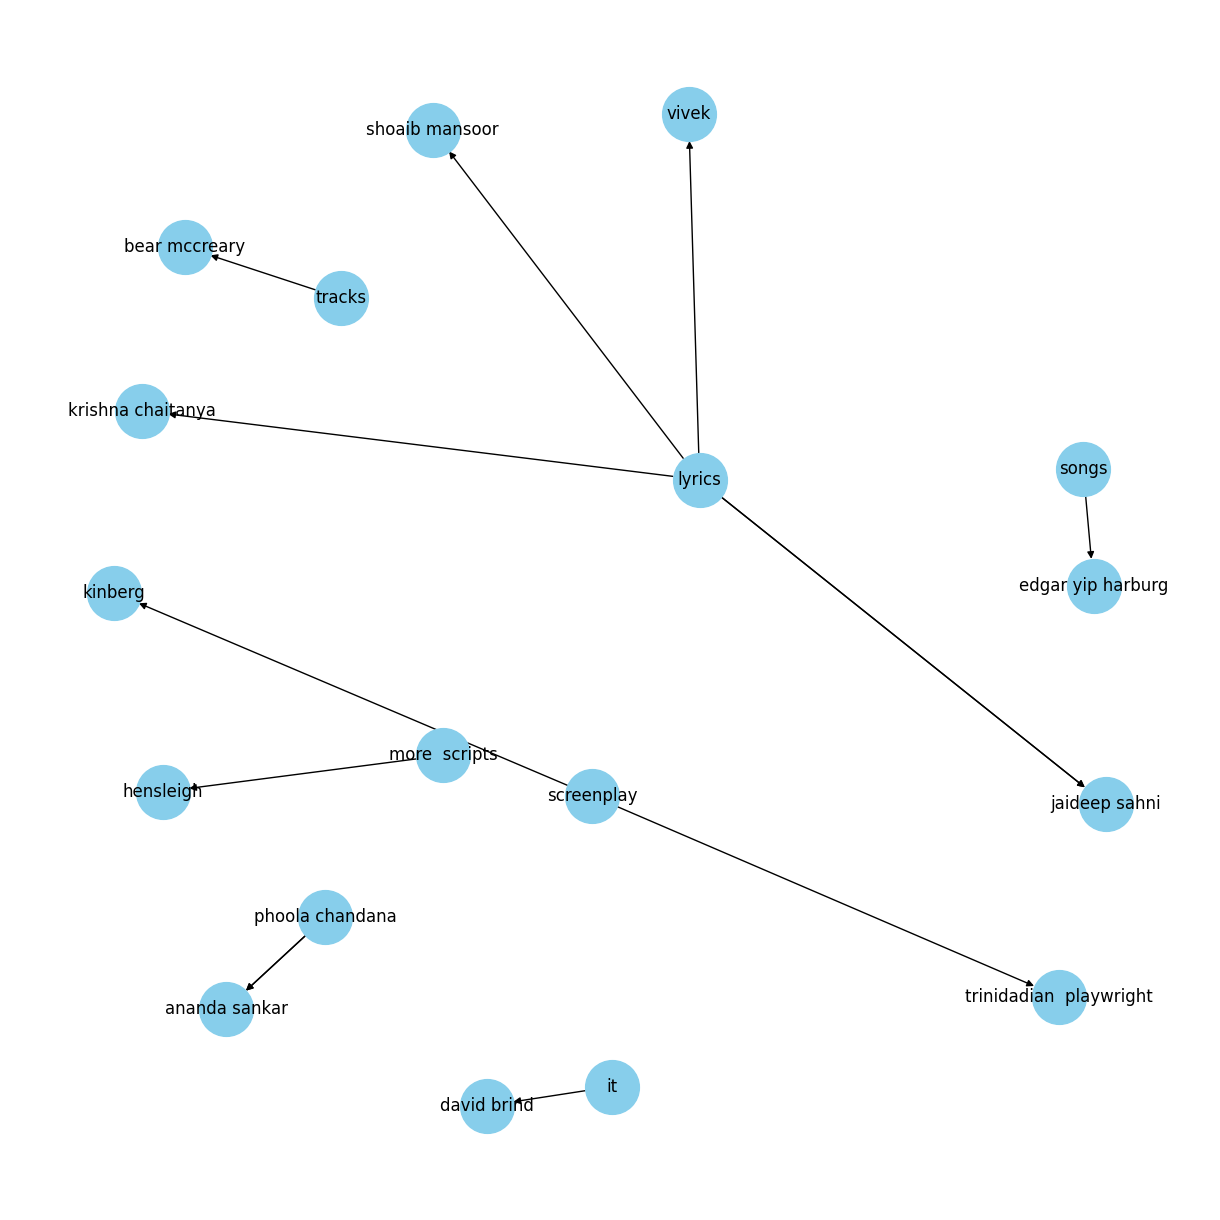

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

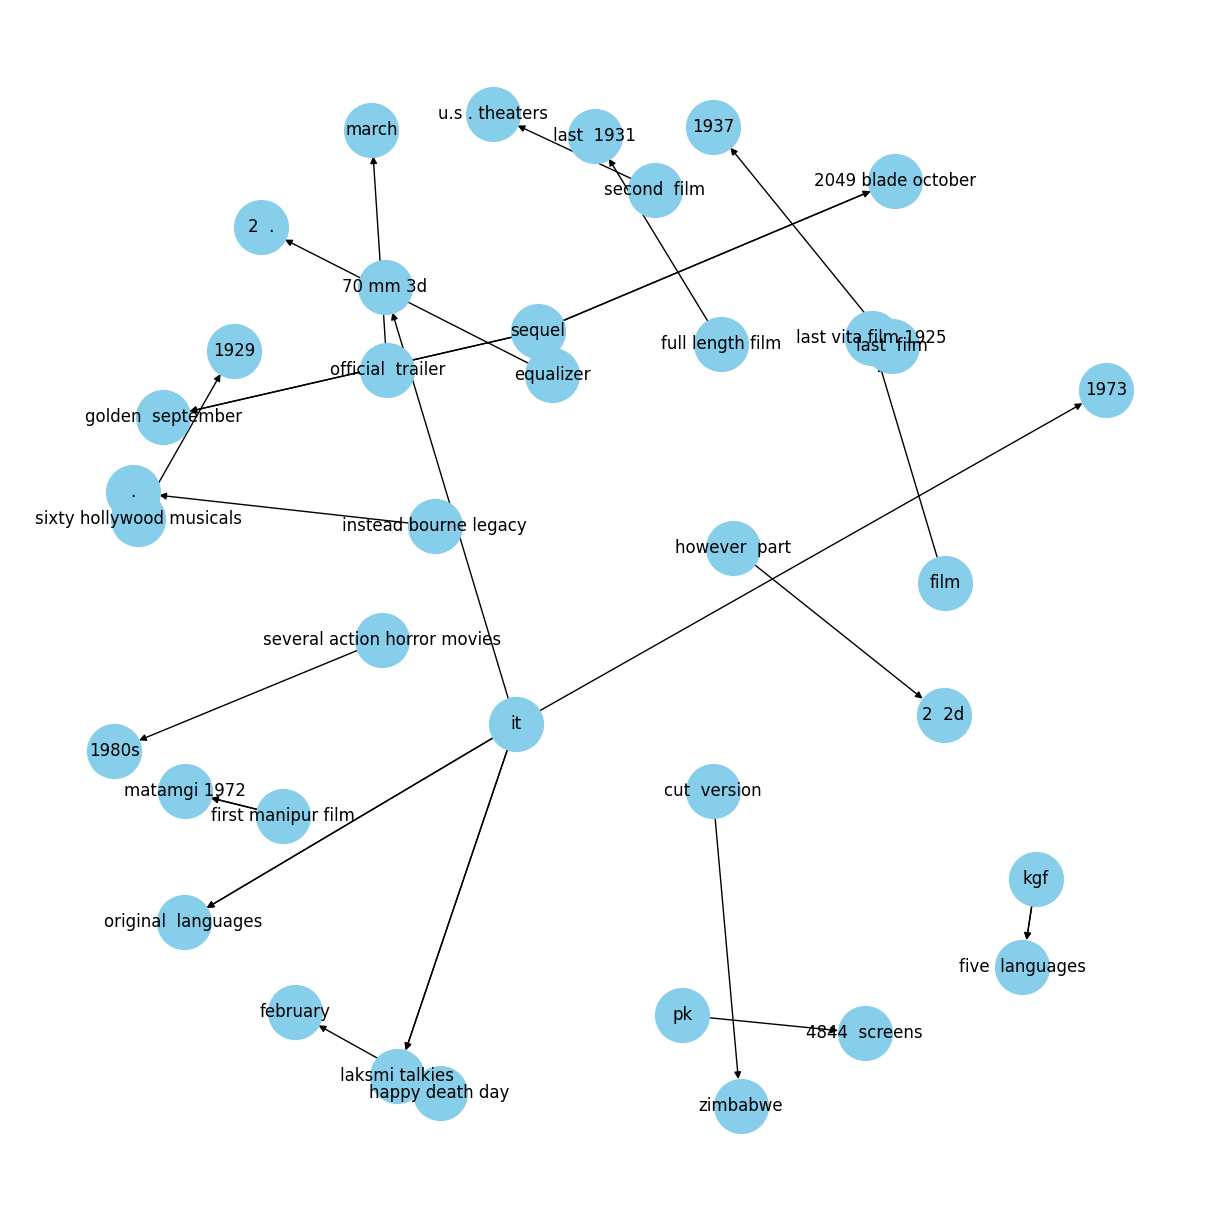

In [21]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

BERT: Bidirectional Encoder Representations from Transformers¶
1.1 What is BERT?
BERT stands for Bidirectional Encoder Representations from Transformers. Let us understand this in detail each word .

Bidirectional - to understand the text you’re looking you’ll have to look back (at the previous words) and forward (at the next words)
Transformers - The Attention Is All You Need paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional,

while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim).
(Pre-trained) contextualized word embeddings - The ELMO paper introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

.3 Why we needed BERT?
One of the biggest challenges in NLP is the lack of enough training data. Overall there is enormous amount of text data available, but if we want to create task-specific datasets, we need to split that pile into the very many diverse fields. And when we do this, we end up with only a few thousand or a few hundred thousand human-labeled training examples. Unfortunately, in order to perform well, deep learning based NLP models require much larger amounts of data — they see major improvements when trained on millions, or billions, of annotated training examples.

To help bridge this gap in data, researchers have developed various techniques for training general purpose language representation models using the enormous piles of unannotated text on the web (this is known as pre-training). These general purpose pre-trained models can then be fine-tuned on smaller task-specific datasets, e.g., when working with problems like question answering and sentiment analysis. This approach results in great accuracy improvements compared to training on the smaller task-specific datasets from scratch. BERT is a recent addition to these techniques for NLP pre-training; it caused a stir in the deep learning community because it presented state-of-the-art results in a wide variety of NLP tasks, like question answering.

The best part about BERT is that it can be download and used for free — we can either use the BERT models to extract high quality language features from our text data, or we can fine-tune these models on a specific task, like sentiment analysis and question answering, with our own data to produce state-of-the-art predictions.

In [22]:
!pip install pytorch-pretrained-bert pytorch-nlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.2 MB/s eta 0:00:00


In [25]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
df = pd.read_csv("/content/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [27]:
df.sample(10)


sentence_source  label label_notes  \
6502            d_98      0           *   
2059           rhl07      1         NaN   
4551            ks08      1         NaN   
1645            r-67      1         NaN   
3291            l-93      0           *   
5282            b_82      0           *   
489             bc01      1         NaN   
646             bc01      1         NaN   
515             bc01      0           *   
3318            l-93      1         NaN   

                                                                    sentence  
6502                                            some answered any question .  
2059                                    all who come will have a good time .  
4551  springfield would have built a police station with the federal grant .  
1645                          i brought john a razor to shave himself with .  
3291                            the square remained with a crowd of people .  
5282                                          how easy to tease john it is !  
489                                                             john tried .  
646                                     dry the baby with the cloth asleep .  
515                                         the electrode was left by ions .  
3318                             in the aquarium there swam a striped fish .

In [28]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values


In [29]:
sentences

["[CLS] our friends wo n't buy this analysis , let alone the next one we propose . [SEP]",
 "[CLS] one more pseudo generalization and i 'm giving up . [SEP]",
 "[CLS] one more pseudo generalization or i 'm giving up . [SEP]",
 '[CLS] the more we study verbs , the crazier they get . [SEP]',
 '[CLS] day by day the facts are getting murkier . [SEP]',
 "[CLS] i 'll fix you a drink . [SEP]",
 '[CLS] fred watered the plants flat . [SEP]',
 '[CLS] bill coughed his way out of the restaurant . [SEP]',
 "[CLS] we 're dancing the night away . [SEP]",
 '[CLS] herman hammered the metal flat . [SEP]',
 '[CLS] the critics laughed the play off the stage . [SEP]',
 '[CLS] the pond froze solid . [SEP]',
 '[CLS] bill rolled out of the room . [SEP]',
 '[CLS] the gardener watered the flowers flat . [SEP]',
 '[CLS] the gardener watered the flowers . [SEP]',
 '[CLS] bill broke the bathtub into pieces . [SEP]',
 '[CLS] bill broke the bathtub . [SEP]',
 '[CLS] they drank the pub dry . [SEP]',
 '[CLS] they dran

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


100%|██████████| 231508/231508 [00:00<00:00, 2621650.91B/s]


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [31]:
MAX_LEN = 128


In [32]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


In [33]:
input_ids

[[101,
  2256,
  2814,
  24185,
  1050,
  1005,
  1056,
  4965,
  2023,
  4106,
  1010,
  2292,
  2894,
  1996,
  2279,
  2028,
  2057,
  16599,
  1012,
  102],
 [101,
  2028,
  2062,
  18404,
  2236,
  3989,
  1998,
  1045,
  1005,
  1049,
  3228,
  2039,
  1012,
  102],
 [101,
  2028,
  2062,
  18404,
  2236,
  3989,
  2030,
  1045,
  1005,
  1049,
  3228,
  2039,
  1012,
  102],
 [101,
  1996,
  2062,
  2057,
  2817,
  16025,
  1010,
  1996,
  13675,
  16103,
  2121,
  2027,
  2131,
  1012,
  102],
 [101, 2154, 2011, 2154, 1996, 8866, 2024, 2893, 14163, 8024, 3771, 1012, 102],
 [101, 1045, 1005, 2222, 8081, 2017, 1037, 4392, 1012, 102],
 [101, 5965, 27129, 1996, 4264, 4257, 1012, 102],
 [101, 3021, 19055, 2010, 2126, 2041, 1997, 1996, 4825, 1012, 102],
 [101, 2057, 1005, 2128, 5613, 1996, 2305, 2185, 1012, 102],
 [101, 11458, 25756, 1996, 3384, 4257, 1012, 102],
 [101, 1996, 4401, 4191, 1996, 2377, 2125, 1996, 2754, 1012, 102],
 [101, 1996, 8644, 10619, 5024, 1012, 102],
 [101, 3021

In [34]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [35]:
input_ids

array([[ 101, 2256, 2814, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       ...,
       [ 101, 2009, 2003, ...,    0,    0,    0],
       [ 101, 1045, 2018, ...,    0,    0,    0],
       [ 101, 2054, 2035, ...,    0,    0,    0]])

In [36]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)


In [37]:
attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0

In [38]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [39]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [40]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [42]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [43]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

In [44]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
t = []

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))




Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


In [ ]:
# Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()